<a href="https://colab.research.google.com/github/worldwidekatie/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Assignment Begins
## Starting with the best I had yesterday

In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np

In [195]:
train, val = train_test_split(train, random_state=42)
train.shape, val.shape

((44550, 41), (14850, 41))

In [0]:
def wrangle(X):
    X = X.copy()
    #Manually replacing NaNs
    X = X.replace({np.NaN: 0})
    # Fixing the high cardinality
    high_card =  ['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 
                  'scheme_name', 'lga', 'region', 'scheme_management', 
                  'extraction_type', 'management', 'source', 'extraction_type_group']
    for i in high_card:
      top10 = X[i].value_counts()[:8].index
      X.loc[~X[i].isin(top10), i] = 'OTHER'
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
target = ['status_group']
features = ['amount_tsh',	'date_recorded',	'funder',	'gps_height',	'installer',	
            'longitude', 'latitude',	'wpt_name',	'num_private',	'basin',	
            'subvillage',	'region',	'region_code',	'district_code',	'lga',	'ward',
            'population',	'public_meeting',	'scheme_management',	'scheme_name',	
            'permit',	'construction_year',	'extraction_type', 'extraction_type_group',
          	'management',	'management_group',	'payment',
            'water_quality',	'quality_group',	'quantity',	'source',
          	'source_class',	'waterpoint_type']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [75]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Train Accuracy: 0.9987429854096521
Validation Accuracy: 0.8033670033670034


In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
import sklearn as sk

In [77]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
param_distributions = { 
    'randomforestclassifier__max_depth': [5, 10, 15, 20] 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='accuracy', 
    verbose=3, 
    return_train_score=True
)

search.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] randomforestclassifier__max_depth=5 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=5, score=(train=0.718, test=0.714), total=   2.7s
[CV] randomforestclassifier__max_depth=5 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=5, score=(train=0.722, test=0.718), total=   1.8s
[CV] randomforestclassifier__max_depth=10 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=10, score=(train=0.785, test=0.757), total=   2.5s
[CV] randomforestclassifier__max_depth=10 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=10, score=(train=0.787, test=0.758), total=   2.5s
[CV] randomforestclassifier__max_depth=15 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=15, score=(train=0.893, test=0.791), total=   3.3s
[CV] randomforestclassifier__max_depth=15 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=15, score=(train=0.889, test=0.790), total=   3.3s
[CV] randomforestclassifier__max_depth=20 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=20, score=(train=0.973, test=0.794), total=   3.8s
[CV] randomforestclassifier__max_depth=20 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=20, score=(train=0.969, test=0.797), total=   3.8s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [78]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20}
Cross-validation MAE -0.7955555555555556


In [0]:
pipeline = search.best_estimator_

In [80]:
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Train Accuracy: 0.9482379349046016
Validation Accuracy: 0.8071380471380472


In [0]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission = submission.set_index('id')
submission.to_csv('katie-submission4.csv')

from google.colab import files
files.download('katie-submission4.csv')

# Now that I got it to work, I'll tweaking additional things

Like adding more things to randomforestclassifier

In [86]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)
param_distributions = { 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='accuracy', 
    verbose=3, 
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [87]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.27204330984309744, 'randomforestclassifier__n_estimators': 261}
Cross-validation MAE -0.7925476992143659


In [0]:
pipeline = search.best_estimator_

In [89]:
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Train Accuracy: 0.8712682379349046
Validation Accuracy: 0.7996632996632996


### Somehow, that actually decreased my accuracy quite a bit... so that's not good.

# On to the next attempt!

In [120]:
df = train

df = df.replace({'functional': 1, 'non functional': 0, 'functional needs repair': .5})
df['status_group'].value_counts()

1.0    24161
0.0    17146
0.5     3243
Name: status_group, dtype: int64

In [0]:
def wrangle(X):
    X = X.copy()
   # X['date_recorded'] = pd.to_datetime(X['date_recorded'])
   # X = X.replace({'functional': 1, 'non functional': 0, 'functional needs repair': .5})
    #Manually replacing NaNs
   # X = X.replace({np.NaN: 0})
    # Fixing the high cardinality
    #high_card =  ['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 
                 # 'scheme_name', 'lga', 'region', 'scheme_management', 
                 # 'extraction_type', 'management', 'source', 'extraction_type_group']
    #for i in high_card:
     # top10 = X[i].value_counts()[:8].index
     # X.loc[~X[i].isin(top10), i] = 'OTHER'
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
target = ['status_group']
#	'date_recorded',
features = ['amount_tsh',	'date_recorded',
            'funder',	'gps_height',	'installer',	
            'longitude', 'latitude',	'wpt_name',	'num_private',	'basin',	
            'subvillage',	'region',	'region_code',	'district_code',	'lga',	'ward',
            'population',	'public_meeting',	'scheme_management',	'scheme_name',	
            'permit',	'construction_year',	'extraction_type', 'extraction_type_group',
          	'management',	'management_group',	'payment',
            'water_quality',	'quality_group',	'quantity',	'source',
          	'source_class',	'waterpoint_type']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [152]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    IterativeImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
param_distributions = { 
    'randomforestclassifier__max_depth': [5, 10, 15, 20] 
}
#'most_frequent', 'constant'
# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='accuracy', 
    verbose=2, 
    return_train_score=True
)

search.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] randomforestclassifier__max_depth=5 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] .............. randomforestclassifier__max_depth=5, total=   3.9s
[CV] randomforestclassifier__max_depth=5 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] .............. randomforestclassifier__max_depth=5, total=   3.8s
[CV] randomforestclassifier__max_depth=10 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] ............. randomforestclassifier__max_depth=10, total=   4.9s
[CV] randomforestclassifier__max_depth=10 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] ............. randomforestclassifier__max_depth=10, total=   4.9s
[CV] randomforestclassifier__max_depth=15 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] ............. randomforestclassifier__max_depth=15, total=   5.8s
[CV] randomforestclassifier__max_depth=15 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] ............. randomforestclassifier__max_depth=15, total=   6.3s
[CV] randomforestclassifier__max_depth=20 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] ............. randomforestclassifier__max_depth=20, total=   6.4s
[CV] randomforestclassifier__max_depth=20 ............................


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV] ............. randomforestclassifier__max_depth=20, total=   6.5s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   46.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [153]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20}
Cross-validation Accuracy -0.7904601571268237


In [0]:
pipeline = search.best_estimator_

In [155]:
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Train Accuracy: 0.9650953984287317
Validation Accuracy: 0.8106397306397306


Woot! Marginally better! Except Kaggle did not thing so :(

In [0]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission = submission.set_index('id')
submission.to_csv('katie-submission5.csv')

from google.colab import files
files.download('katie-submission5.csv')

# Gonna try one last thing...

*  Engineering a feature that's how many days ago it was recorded from the most recently recorded day




In [176]:
train['date_recorded'] = pd.to_datetime(train['date_recorded'])

train['date_recorded'].describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [178]:
train['recent_rec'] = ['2013-12-03 00:00:00'] * len(y_train)
train['recent_rec'] = pd.to_datetime(train['recent_rec'])
train['recent_rec'].describe()

train['date_days'] = train['recent_rec'] - train['date_recorded']
train['date_days'].value_counts().head()

994 days    572
992 days    558
303 days    546
995 days    520
993 days    513
Name: date_days, dtype: int64

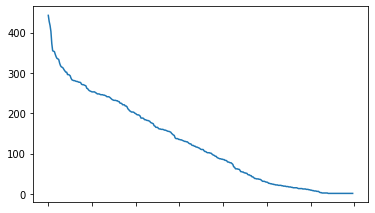

In [170]:
import matplotlib.pyplot as plt

df = train['date_days'].value_counts()
df.plot();

In [180]:
train['date_days'] = train['date_days'].astype('timedelta64[D]')
train['date_days'].describe()

count    59400.000000
mean       613.616970
std        334.216374
min          0.000000
25%        297.000000
50%        419.000000
75%        977.000000
max       4068.000000
Name: date_days, dtype: float64

In [0]:
def wrangle(X):
    X = X.copy()
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['recent_rec'] = ['2013-12-03 00:00:00'] * len(X)
    X['recent_rec'] = pd.to_datetime(X['recent_rec'])
    X['date_days'] = X['recent_rec'] - X['date_recorded']
    X['date_days'] = X['date_days'].astype('timedelta64[D]')

     #Fixing the high cardinality
    high_card =  ['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 
                  'scheme_name', 'lga', 'region', 'scheme_management', 
                  'extraction_type', 'management', 'source', 'extraction_type_group']
    for i in high_card:
      top10 = X[i].value_counts()[:10].index
      X.loc[~X[i].isin(top10), i] = 'OTHER'
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
target = ['status_group']

features = ['amount_tsh',	'date_days',
            'funder',	'gps_height',	'installer',	
            'longitude', 'latitude',	'wpt_name',	'num_private',	'basin',	
            'subvillage',	'region',	'region_code',	'district_code',	'lga',	'ward',
            'population',	'public_meeting',	'scheme_management',	'scheme_name',	
            'permit',	'construction_year',	'extraction_type', 'extraction_type_group',
          	'management',	'management_group',	'payment',
            'water_quality',	'quality_group',	'quantity',	'source',
          	'source_class',	'waterpoint_type']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [199]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    IterativeImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
param_distributions = { 
    'randomforestclassifier__n_estimators': randint(10, 100),
    'randomforestclassifier__max_depth': [20, 21, 22, 23, 24, 25], 

}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=7, 
    cv=2, 
    scoring='accuracy', 
    verbose=2, 
    return_train_score=True
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[CV] randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=76 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=76, total=   6.2s
[CV] randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=76 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=76, total=   5.2s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=15 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=15, total=   2.8s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=15 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=15, total=   2.8s
[CV] randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=41 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=41, total=   3.7s
[CV] randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=41 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=41, total=   3.7s
[CV] randomforestclassifier__max_depth=23, randomforestclassifier__n_estimators=77 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=23, randomforestclassifier__n_estimators=77, total=   5.2s
[CV] randomforestclassifier__max_depth=23, randomforestclassifier__n_estimators=77 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=23, randomforestclassifier__n_estimators=77, total=   5.2s
[CV] randomforestclassifier__max_depth=21, randomforestclassifier__n_estimators=75 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=21, randomforestclassifier__n_estimators=75, total=   5.0s
[CV] randomforestclassifier__max_depth=21, randomforestclassifier__n_estimators=75 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=21, randomforestclassifier__n_estimators=75, total=   5.0s
[CV] randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=86 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=86, total=   5.5s
[CV] randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=86 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=24, randomforestclassifier__n_estimators=86, total=   5.5s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=84 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=84, total=   5.4s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=84 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__n_estimators=84, total=   5.4s


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [200]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)
pipeline = search.best_estimator_
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Best hyperparameters {'randomforestclassifier__max_depth': 23, 'randomforestclassifier__n_estimators': 77}
Cross-validation Accuracy -0.7949270482603816
Train Accuracy: 0.9760044893378227
Validation Accuracy: 0.808956228956229


This, again, was not an improvement on my best score! :(

In [0]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission = submission.set_index('id')
submission.to_csv('katie-submission6.csv')

from google.colab import files
files.download('katie-submission6.csv')